# Tutorial: Deconvolving with GP model

In this tutorial we will be deconvolving a bulk data set using the Gaussian Process trajectory model and generating all possible output plots as well as extracting calculated sample and trajectory values.

## Initialize
We first load the required libraries and set a global configuration that we will need later. This includes the number of iterations we want to run in our training loop and initializing a `DeconvolutionDatatypeParametrization` object that holds the datatypes we will be using for the deconvolution.

The recommended number of iterations for deconvolution is >20,000, however for brevity of execution we here use a smaller number of iterations.

In [1]:
# import 
import torch
import matplotlib.pyplot as plt

from ternadecov.simulator import *
from ternadecov.time_deconv import *
from ternadecov.time_deconv import *
from ternadecov.simulator import *
from ternadecov.stats_helpers import *
from ternadecov.dataset import *
from ternadecov.deconvolution_plotter import *
from ternadecov.parametrization import *
from ternadecov.evaluation import evaluate_with_trajectory
from ternadecov.deconvolution_writer import DeconvolutionWriter
from ternadecov.deconvolution_exporter import DeconvolutionExporter

In [2]:
# configure
n_iters = 5_000
datatype_param = DeconvolutionDatatypeParametrization()

### Load data
Next we load the datasets that we will use. We need two datasets, both in AnnData format. One dataset will be the bulk RNA-seq dataset that we want to deconvolve. This dataset must have a column under .obs that provides the time at which each particular sample is collected. The name of this column doesn't matter as it can be specified while configuring the deconvolution.

In [3]:
# paths to h5ad files containing the AnnData object
sc_anndata_path = "/home/nbarkas/disk2/deconvolution_method/datasets/ebov/load_data_python/ebov_sc.h5ad"
bulk_anndata_path = 'simulated_linear.h5ad'

# load the files -- this take a while
with open(bulk_anndata_path, 'rb') as fh:
    bulk_anndata  = anndata.read_h5ad(fh)
with open(sc_anndata_path, 'rb') as fh:
    sc_anndata = anndata.read_h5ad(fh)

### Perform deconvolution
Next we perform the deconvolution. The first step to performing the deconvolution is to generate a `DeconvolutionDataset` object. This object contains all input data to the deconvolution, including the single-cell used as reference and bulk data we are deconvolving. The object is also responsible for selecting the genes that we will use for the deconvolution at the next step. The most important parameter to specify here is `feature_selection_method` that defines the algorithm that is used to select genes. In general we want to use maximally informative genes in both datasets. 

The `common` method used below uses all genes that are present in both datasets. It is generally not suitable for deconvolution except for the case of simulated datasets (as we have here). If in doubt do not specify the value and allow the default `overdispersed_bulk_and_high_sc` to be selected. In this mode genes that are both overdispersed in the bulk and also hightly expressed in the single-cell data are used. The cutoffs for both over-dispersion and high expression can be manually specified. Consult the object documentation for more information.

In [4]:
ebov_simulated_dataset = DeconvolutionDataset(
    types=datatype_param,
    parametrization = DeconvolutionDatasetParametrization(
        sc_anndata = sc_anndata,
        sc_celltype_col = "Subclustering_reduced",
        bulk_anndata = bulk_anndata,
        bulk_time_col = "time",
        feature_selection_method = 'common'
    )       
)

12180 genes selected


Next we generate a `TimeRegularizedDeconvolutionModel`, which is the object that will perform the deconvolution. In additoion to the dataset generated above we need to specify parameters indicating what trajectory model for deconvolution we should want to use. In this case we are using a gaussian process model by seeting `trajectory_model_type = 'gp'`. Different trajectory model types require different sets of paraters, the required ones for GP deconvolution are specified here.

In [5]:
pseudo_time_reg_deconv_sim = TimeRegularizedDeconvolutionModel(
    dataset=ebov_simulated_dataset,
    trajectory_model_type='gp',
    hyperparameters=TimeRegularizedDeconvolutionModelParametrization(),
    trajectory_hyperparameters=TimeRegularizedDeconvolutionGPParametrization(),
    types=datatype_param)

Finally we execute the training loop by calling `.fit_model()` with the desired number of iterations. If we want to continue previous training we can set `clear_param_store` to False and continue the training we hve already started.

In [6]:
pseudo_time_reg_deconv_sim.fit_model(
    n_iters=n_iters, 
    verbose=True, 
    log_frequency=1000,
    clear_param_store = True,
    keep_param_store_history=False
)

[step: 0, time: 1 s ] loss: 7172269.80
[step: 1000, time: 72 s ] loss: 5318734.33
[step: 2000, time: 144 s ] loss: 4571008.94
[step: 3000, time: 216 s ] loss: 4265310.94
[step: 4000, time: 288 s ] loss: 4162190.77


### Examine Outputs
Next we want to examine the outputs of our deconvolution. `ternadecov` provides two object classes for viewing and examing the data the `DeconvolutionPlotter` and the `DeconvolutionWriter`. The former object generates (and saves) plots while the latter outputs and saves data in tabular format.

We start by making a `DeconvolutionPlotter`.

In [7]:
plotter = DeconvolutionPlotter(pseudo_time_reg_deconv_sim)

First we plot the loss as a function of the training iteration.

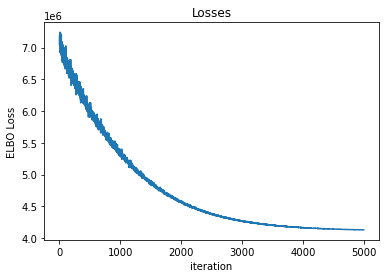

In [8]:
# plot the losses
plotter.plot_loss()
plt.show()

Next we plot the distribution of the $phi_g$ values. These are the gene-specific dispersion values.

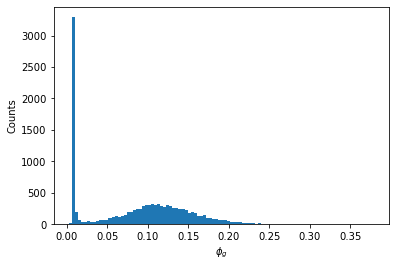

In [9]:
# examine the per-gene dispersions
plotter.plot_phi_g_distribution()
plt.show()

Next we plot the distibution of the $\beta_g$ values. These are gene-specific capture rates for the single-cell data reference generration.

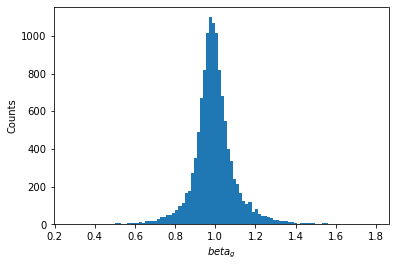

In [10]:
# examine the gene-specific capture rates
plotter.plot_beta_g_distribution()
plt.show()

We can now generate a plot of sample-specific compositons in scatter format.

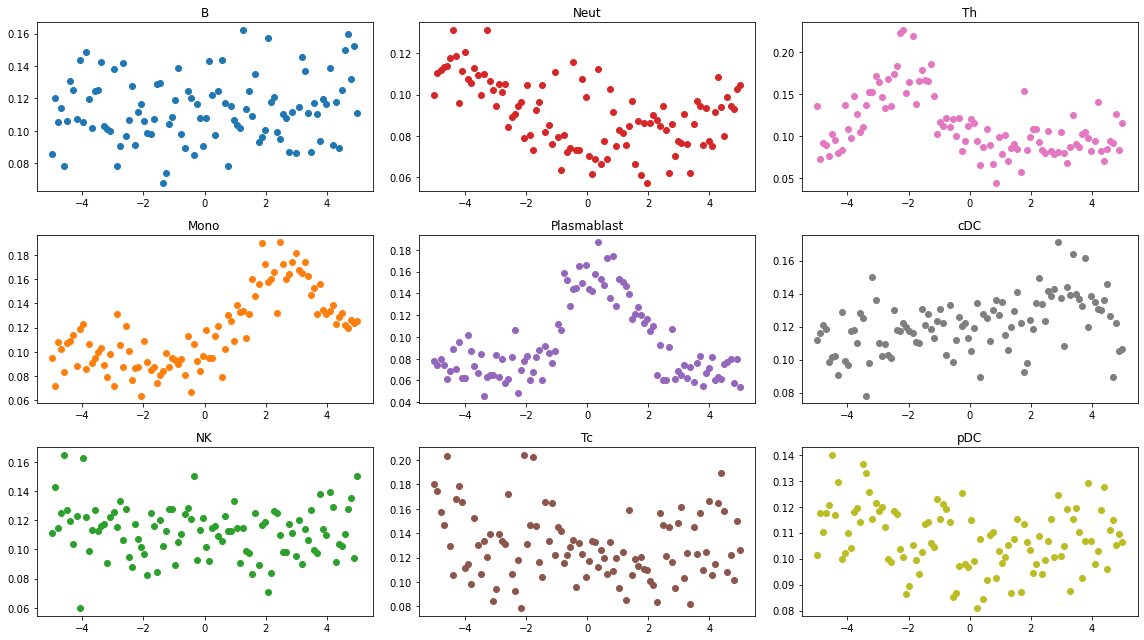

In [11]:
# Plot samples specific compositions in scatter format
plotter.plot_sample_compositions_scatter()

A better way to examine the output trajectories is to directly draw trajectory samples from the posterior. This allows us to ascertain the confidence in the trajectory estimation. The following function draws samples form the posterior and calculates IQR ranges of the trajectories.

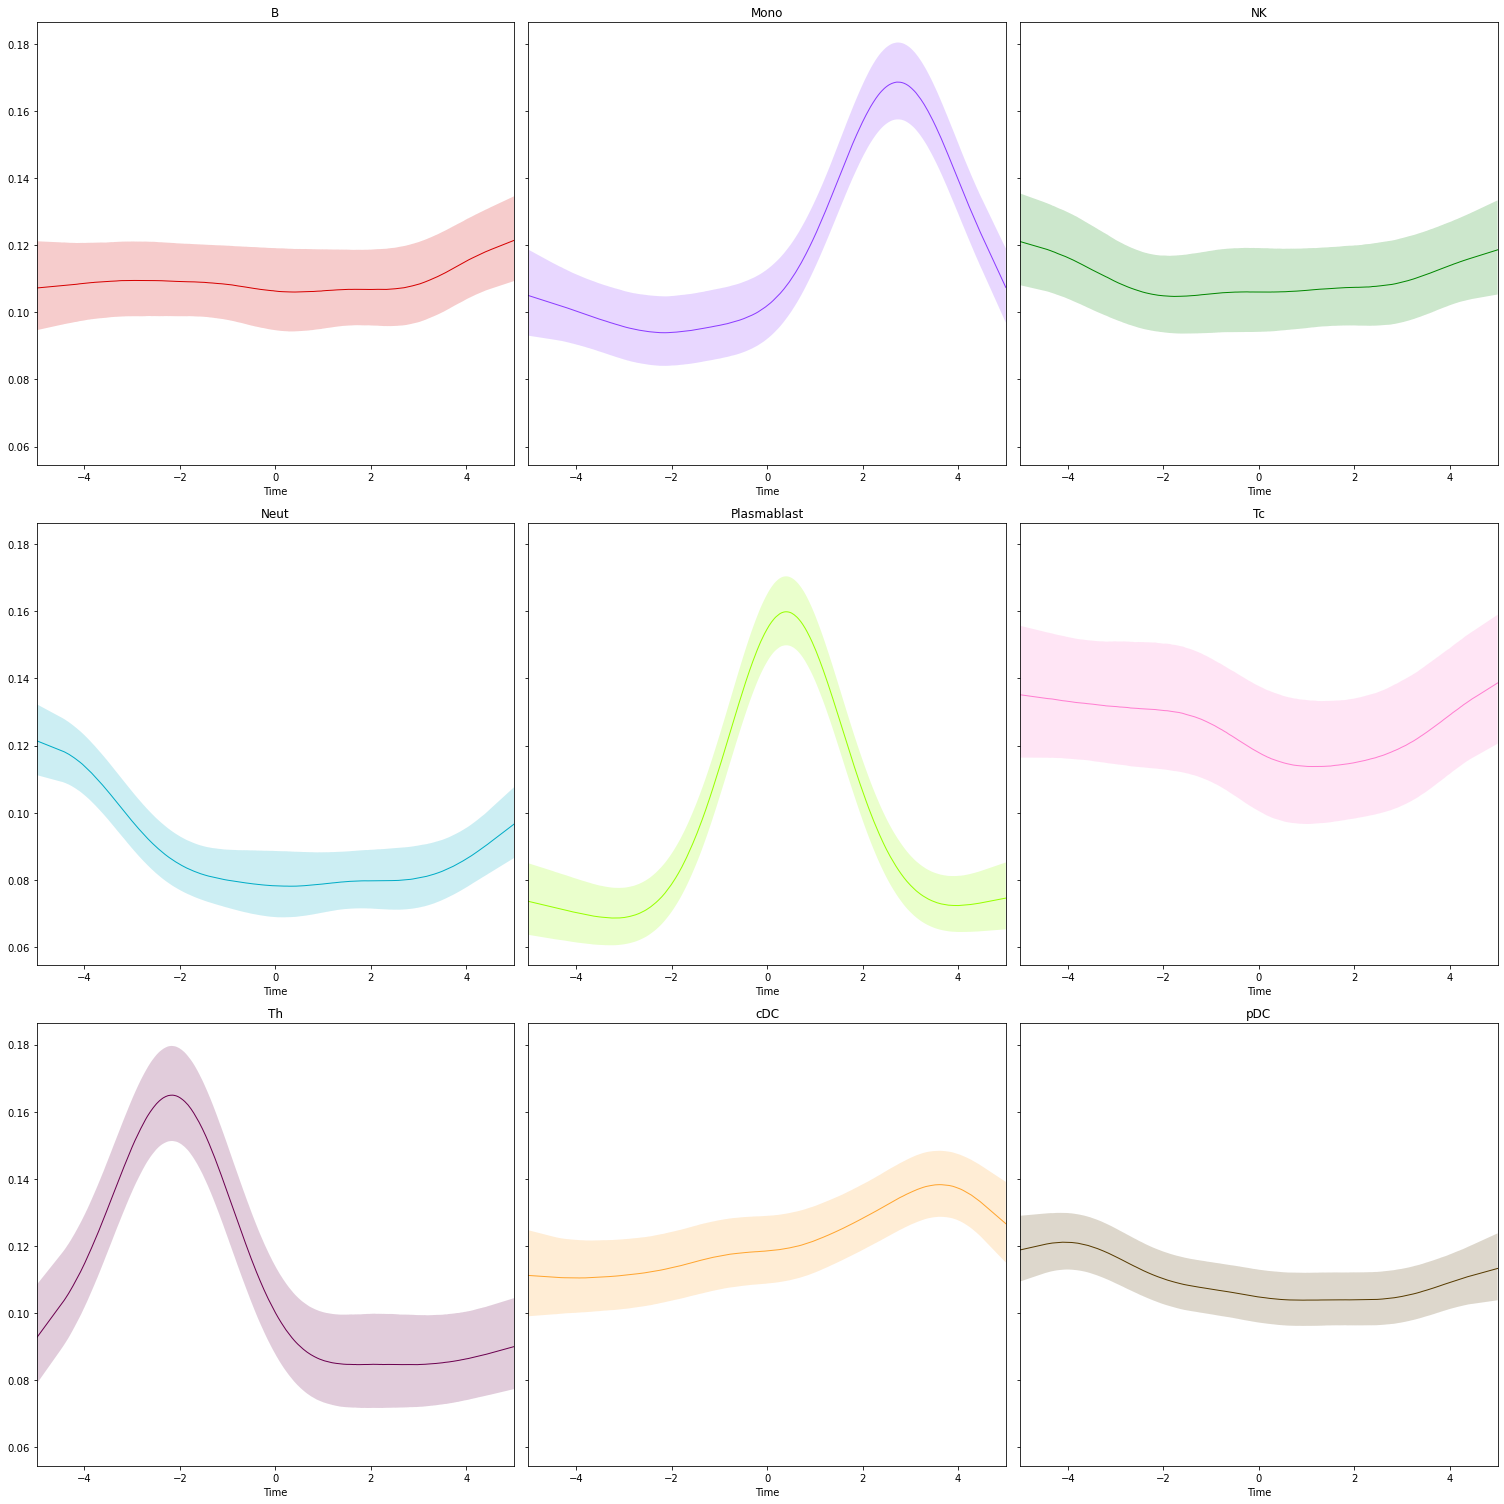

In [12]:
plotter.plot_composition_trajectories_via_posterior_sampling(figsize=(7.0,7.0),show_combined=False)

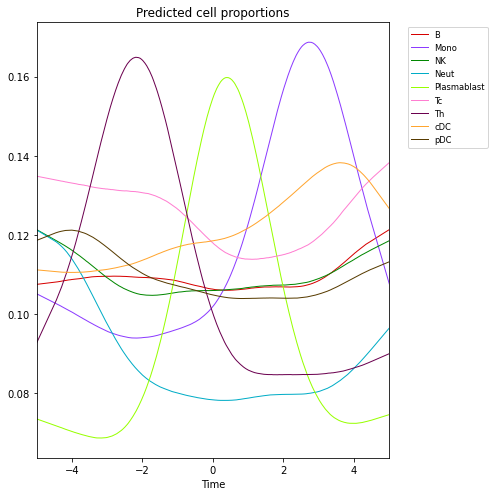

In [13]:
# A different parametrization of the sample function will provide a combined plot
plotter.plot_composition_trajectories_via_posterior_sampling(
    figsize=(7.0,7.0),
    show_combined=True,
    show_iqr=False)

The following function provides an alternative way of plotting the GP trajectory data

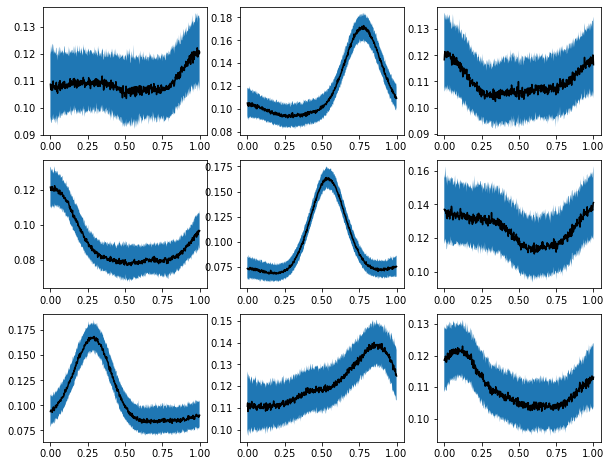

In [14]:
plotter.plot_gp_composition_trajectories()

In addition to plotting trajectories we can directly plot posterior estimates for individual samples. the following function provides posterior estimates for the composition of each sample.

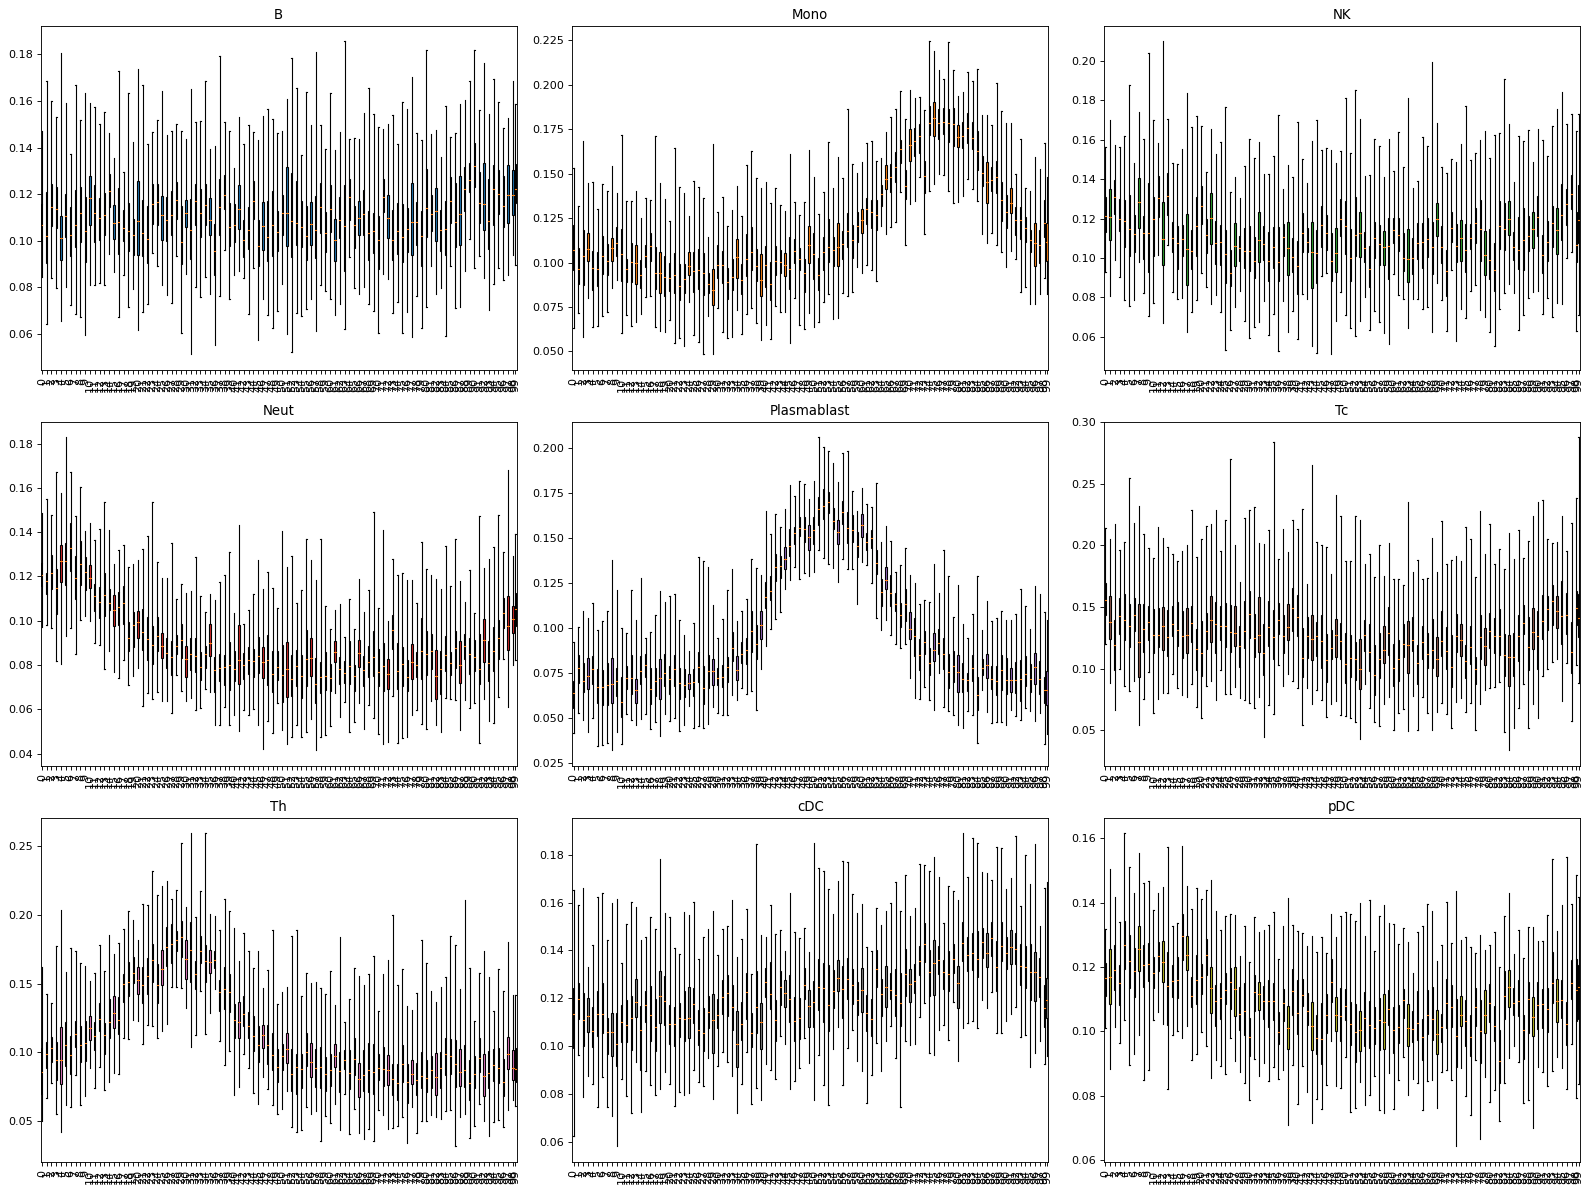

In [15]:
plotter.plot_sample_compositions_boxplot_confidence()

Alternatively we can plot point estimates for the composition of each sample as a boxplot. In this particular dataset where we only have one sample at each time point this plot is not very informative.

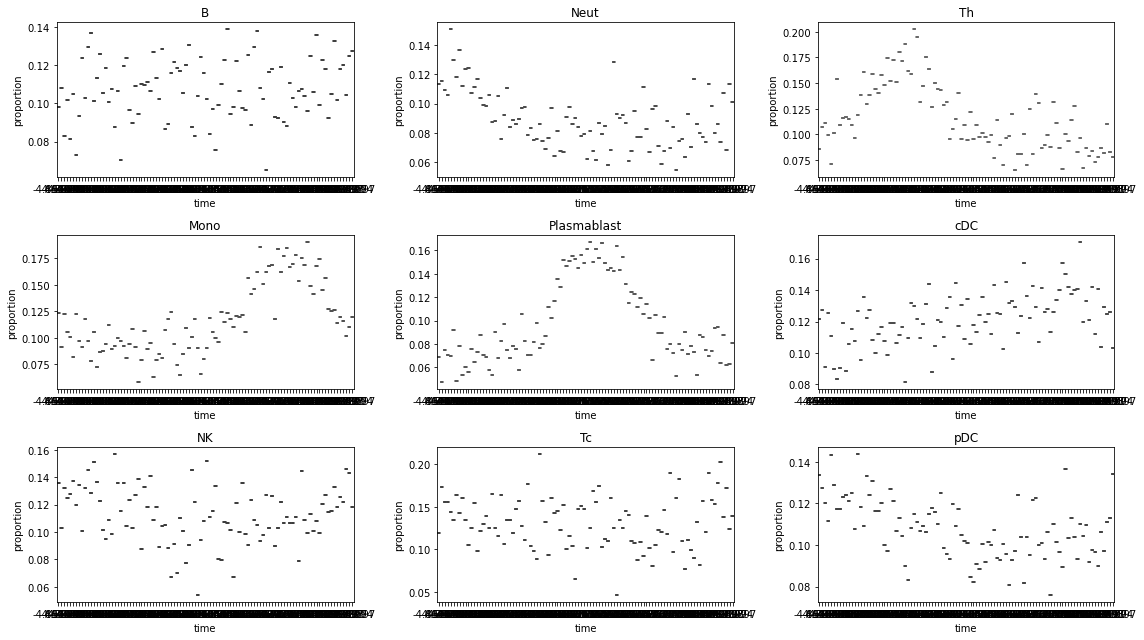

In [16]:
plotter.plot_sample_compositions_boxplot()
matplotlib.pyplot.show()

An alternative way plotting composition trajectories is by directly plotting the mean trajectory from the GP (as opposed the the mean of samples). This is less noisy that the plot above, buyt does not provide and information on the error estimates of each plot.

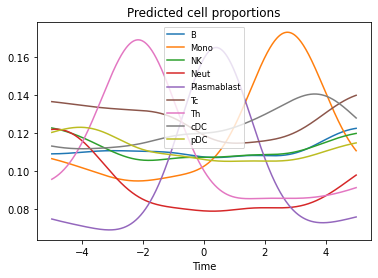

In [17]:
plotter.plot_composition_trajectories()

### Summarizing cell types into super-groups
In some cases we want to be able to summarize different celltypes together. An example of this is to summarize tissue specific vs tissue infiltrating cells or generalize our annotation to general scale cell-types and avoid the confusion be excessive granularity. 

In order to do this we need to define a custom cell type summarization map, as well as a custom color scheme.

In [18]:
celltype_summarization = {
    'typeA': ('B','Mono','NK','Neut'),
    'typeB': ('Plasmablast','Tc','Th','cDC','pDC')
}

colors = {'typeA': 'red', 'typeB': 'blue'}

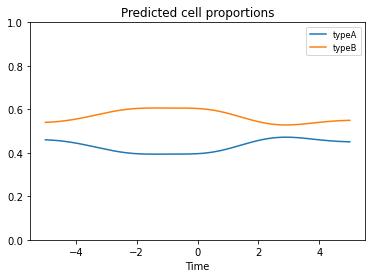

In [19]:
plotter.plot_summarized_cell_compositions(celltype_summarization = celltype_summarization, )
matplotlib.pyplot.show()

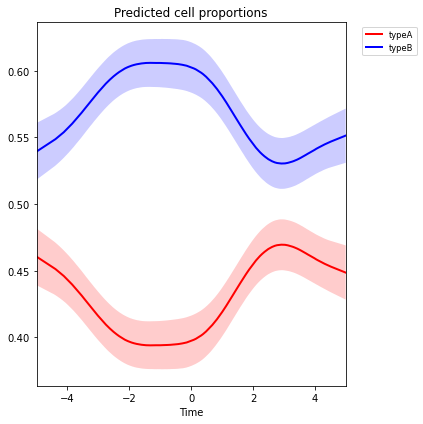

In [20]:
plotter.plot_composition_trajectories_via_posterior_sampling(
    iqr_alpha=0.2,
    show_combined=True,
    ncols=3,
    lw=2.,
    figsize=(6,6),
    sharey=False,
    celltype_summarization=celltype_summarization,
    cell_type_to_color_dict = colors,    
)

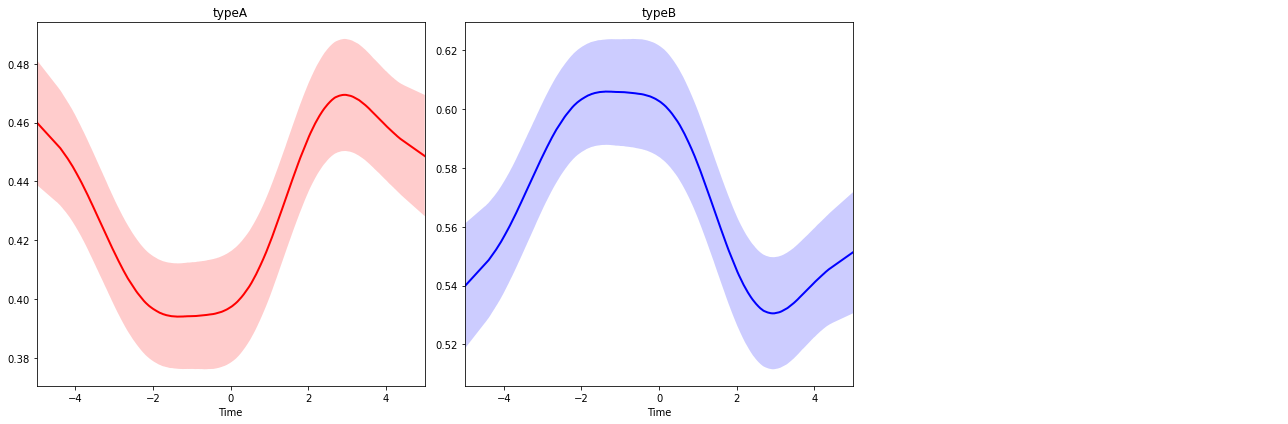

In [21]:
plotter.plot_composition_trajectories_via_posterior_sampling(
    iqr_alpha=0.2,
    show_combined=False,
    ncols=3,
    lw=2.,
    figsize=(6,6),
    sharey=False,
    celltype_summarization=celltype_summarization,  
    cell_type_to_color_dict = colors,     
)

### Extracting values
Finally, we may wish to extract specific estimates from the deconvolution. We can do this with the help of the `DeconvolutionWriter`, which can both return data in tabular (usually pandas) format, or write them to disk using the `filename` argument.

In [22]:
writer = DeconvolutionWriter(pseudo_time_reg_deconv_sim)

In [23]:
writer.write_summarized_cell_compositions(
    return_table = True,
    celltype_summarization=celltype_summarization
)

,Time,Component,percent
0,-5.00000,typeA,0.459848
1,-4.98999,typeA,0.459799
2,-4.97998,typeA,0.459748
3,-4.96997,typeA,0.459695
4,-4.95996,typeA,0.459640
...,...,...,...
1995,4.95996,typeB,0.549255
1996,4.96997,typeB,0.549292
1997,4.97998,typeB,0.549329
1998,4.98999,typeB,0.549365


In [24]:
writer.write_cell_compositions(return_table = True)

,Time,Component,percent
0,-5.00000,B,0.108993
1,-4.98999,B,0.108994
2,-4.97998,B,0.108995
3,-4.96997,B,0.108997
4,-4.95996,B,0.108998
...,...,...,...
8995,4.95996,pDC,0.114611
8996,4.96997,pDC,0.114644
8997,4.97998,pDC,0.114677
8998,4.98999,pDC,0.114709


In [25]:
writer.write_sample_draws_quantiles(return_table = True)

,quantile,sample,celltype,values
0,0,0,B,0.081109
1,0,0,Mono,0.059042
2,0,0,NK,0.085246
3,0,0,Neut,0.096341
4,0,0,Plasmablast,0.036814
...,...,...,...,...
4495,4,99,Plasmablast,0.127384
4496,4,99,Tc,0.266089
4497,4,99,Th,0.192196
4498,4,99,cDC,0.168015


# Exporting all outputs
Finally it is possible to export all the results from ternadecov using the `DeconvolutionExporter` object. This object uses the plotter and writer above to generate all available plots and save the in a specified directory with minimal user intervention. Consult the manual of the `DeconvolutionExporter` object for more information on how to use it.